run cell below and restart runtime

In [4]:
!pip install python-bidi
!pip install python-bidi arabic-reshaper

  Using cached arabic_reshaper-3.0.0-py3-none-any.whl.metadata (12 kB)
Using cached arabic_reshaper-3.0.0-py3-none-any.whl (20 kB)


In [1]:
!pip install transformers[torch] accelerate -U
!pip install datasets
!pip install transformers
!pip install -q transformers
!pip install -q clean-text[gpl]
!pip install iterative-stratification
!pip install hazm
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.3/324.3 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.33.0
    Uninstalling accelerate-0.33.0:
      Successfully uninstalled accelerate-0.33.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 kB 4.8 MB/s eta 0:00:00
ERROR: Operation cancelled by user


#initial setup

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import pandas as pd
import os
from os import path
import seaborn as sns
from tqdm.notebook import tqdm
import hazm
from cleantext import clean
import plotly.express as px
import plotly.graph_objects as go
from tqdm.notebook import tqdm
from tqdm import tqdm
import re
import json
import string
import copy
import collections
from collections import Counter
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer,IntervalStrategy
from datasets import Dataset,load_dataset, DatasetDict
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from bidi.algorithm import get_display
import arabic_reshaper
from nltk import ngrams

In [6]:
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import classification_report,accuracy_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from scipy.special import expit

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [8]:
pip show transformers accelerate

Name: transformers
Version: 4.44.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 
---
Name: accelerate
Version: 0.34.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


#Models

*   List models



In [9]:
# fasttext              facebook/fasttext-language-identification

# RCNN
# RCNNVariant
# TextAttBiRNN
# TextBiRNN
# TextRNN

# ParsBERT              HooshvareLab/bert-fa-base-uncased         HooshvareLab/bert-base-parsbert-uncased     HooshvareLab/bert-fa-base-uncased-ner-peyma
# XLM-Roberta-base      FacebookAI/xlm-roberta-base
# XLM-Roberta-large     FacebookAI/xlm-roberta-large
# XLM-EMO-T             MilaNLProc/xlm-emo-t

# bert                      google-bert/bert-base-multilingual-uncased
# distil-roberta-base       distilbert/distilroberta-base
# distil-bert               distilbert/distilbert-base-uncased
#distil-bert multilingual   distilbert/distilbert-base-multilingual-cased
#DeBERTAV3                  microsoft/mdeberta-v3-base
#DeBERTA-base               microsoft/deberta-base
#albert-base                albert/albert-base-v2
#xlnet-base                 xlnet/xlnet-base-cased
#t5                         google-t5/t5-base








#not transformers format: "fasttext"                                        "facebook/fasttext-language-identification",

# hould config and run seperately :"funnel-transformers-medium"              "funnel-transformer/medium",
# not work and problem in batch size              "MilaNLProc/xlm-emo-t",


In [94]:
models_list_1=[
             "funnel-transformer/medium",
             "google/electra-base-discriminator",
             "facebook/bart-base",
             "facebook/bart-large",
             "HooshvareLab/bert-fa-base-uncased",
             "FacebookAI/xlm-roberta-base",
          ]
model_list_2=[
    "FacebookAI/xlm-roberta-large",
     "google-bert/bert-base-multilingual-uncased",
     "distilbert/distilroberta-base",
     "distilbert/distilbert-base-uncased",
     "distilbert/distilbert-base-multilingual-cased",
     "microsoft/mdeberta-v3-base",
     "albert/albert-base-v2",
     "xlnet/xlnet-base-cased",
     "google-t5/t5-base",
      ]

models_name_1=[
"funnel-transformer-medium",
'electra-base',
"bart-base",
"bart-large",
"ParsBERT",
"XLM-Roberta-base",
]

models_name_2=[
"XLM-Roberta-large",
"bert",
"distil-roberta-base",
"distil-bert",
"distil-bert multilingual",
"DeBERTAV3",
"albert-base",
"xlnet-base",
"t5",
]

#Load Data

In [ ]:
# base_data=pd.read_csv("/content/drive/MyDrive/chatbot dataset/final_labeled_chats.csv")
# base_data=base_data.drop(columns={'Unnamed: 8','relative_message'})


In [ ]:
type(base_data.iloc[0].message)

str

In [ ]:
base_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1262 entries, 0 to 1261
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   username     1262 non-null   object
 1   created_at   1262 non-null   object
 2   message      1262 non-null   object
 3   response     1262 non-null   object
 4   emotion      1262 non-null   object
 5   disorder     1262 non-null   object
 6   validation   1262 non-null   object
 7   label        1262 non-null   int64 
 8   related      1262 non-null   int64 
 9   not-related  1262 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 98.7+ KB


In [ ]:
base_data.head()

,username,created_at,message,response,emotion,disorder,validation,label,related,not-related
0,test2,2024-08-11 10:27:42.951347+00:00,سلام,از این که با من در میان گذاشتید خوشحالم. چطور ...,"{'OTHER': 0.01733604446053505, 'HAPPY': 0.6017...","{'Not Stressed': 0.9525769352912903, 'Stressed...",[],1,1,0
1,test2,2024-08-11 10:28:00.300694+00:00,اسم تو چیست,به من می‌توانید با عنوان راهنما یاد کنید. من ا...,"{'OTHER': 0.022789059206843376, 'HAPPY': 0.060...","{'Not Stressed': 0.9497029185295105, 'Stressed...",[],1,1,0
2,test2,2024-08-11 10:28:51.753344+00:00,امروز کمی سردرد دارم,متوجه شدم که امروز کمی سردرد دارید. گاهی اوقات...,"{'OTHER': 0.478849321603775, 'HAPPY': 0.054604...","{'Not Stressed': 0.10206229239702225, 'Stresse...",[],1,1,0
3,test2,2024-08-11 10:29:44.775521+00:00,امروز کمی سردرد دارم,احساس ناراحتی که شما تجربه می‌کنید می‌تواند بی...,"{'OTHER': 0.478849321603775, 'HAPPY': 0.054604...","{'Not Stressed': 0.10206229239702225, 'Stresse...",[],1,1,0
4,test2,2024-08-11 10:30:43.400752+00:00,امروز کمی سردرد دارم,طبق اطلاعاتی که در دست دارم، متوجه شده‌ام که م...,"{'OTHER': 0.478849321603775, 'HAPPY': 0.054604...","{'Not Stressed': 0.10206229239702225, 'Stresse...",[],1,1,0


#Preprocess(Base)

In [ ]:
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext


def cleaning(text):
    text = text.strip()

    # regular cleaning
    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=False,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",
    )

    # cleaning htmls
    text = cleanhtml(text)

    # normalizing
    normalizer = hazm.Normalizer()
    text = normalizer.normalize(text)

    # removing wierd patterns
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)

    text = wierd_pattern.sub(r'', text)

    # removing extra spaces, hashtags
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text)

    return text

**Normalize** and clean textS

In [ ]:
tqdm.pandas()

base_data['clean_message'] = base_data['message'].progress_apply(cleaning)
base_data['cleaned_text_len_by_words'] = base_data['clean_message'].progress_apply(lambda t: len(hazm.word_tokenize(t)))

100%|██████████| 1262/1262 [00:00<00:00, 2068.71it/s]


In [ ]:
# base_data_fa = base_data.dropna(subset=['cleaned_farsi_text_len_by_words'])
base_data_fa = base_data.reset_index(drop=True)

In [ ]:
base_data_fa.head()

,username,created_at,message,response,emotion,disorder,validation,label,related,not-related,clean_message,cleaned_text_len_by_words
0,test2,2024-08-11 10:27:42.951347+00:00,سلام,از این که با من در میان گذاشتید خوشحالم. چطور ...,"{'OTHER': 0.01733604446053505, 'HAPPY': 0.6017...","{'Not Stressed': 0.9525769352912903, 'Stressed...",[],1,1,0,سلام,1
1,test2,2024-08-11 10:28:00.300694+00:00,اسم تو چیست,به من می‌توانید با عنوان راهنما یاد کنید. من ا...,"{'OTHER': 0.022789059206843376, 'HAPPY': 0.060...","{'Not Stressed': 0.9497029185295105, 'Stressed...",[],1,1,0,اسم تو چیست,3
2,test2,2024-08-11 10:28:51.753344+00:00,امروز کمی سردرد دارم,متوجه شدم که امروز کمی سردرد دارید. گاهی اوقات...,"{'OTHER': 0.478849321603775, 'HAPPY': 0.054604...","{'Not Stressed': 0.10206229239702225, 'Stresse...",[],1,1,0,امروز کمی سردرد دارم,4
3,test2,2024-08-11 10:29:44.775521+00:00,امروز کمی سردرد دارم,احساس ناراحتی که شما تجربه می‌کنید می‌تواند بی...,"{'OTHER': 0.478849321603775, 'HAPPY': 0.054604...","{'Not Stressed': 0.10206229239702225, 'Stresse...",[],1,1,0,امروز کمی سردرد دارم,4
4,test2,2024-08-11 10:30:43.400752+00:00,امروز کمی سردرد دارم,طبق اطلاعاتی که در دست دارم، متوجه شده‌ام که م...,"{'OTHER': 0.478849321603775, 'HAPPY': 0.054604...","{'Not Stressed': 0.10206229239702225, 'Stresse...",[],1,1,0,امروز کمی سردرد دارم,4


In [ ]:
base_data_fa.to_csv("/content/drive/MyDrive/chatbot dataset/generalize-v2.csv")

#Preprocess(level2)

In [ ]:
base_data_fa=pd.read_csv("/content/drive/MyDrive/chatbot dataset/generalize-v2.csv")
base_data_fa=base_data_fa.drop(columns={'Unnamed: 0','created_at','username','emotion','disorder','validation'})
base_data_fa

,message,response,label,related,not-related,clean_message,cleaned_text_len_by_words
0,سلام,از این که با من در میان گذاشتید خوشحالم. چطور ...,1,1,0,سلام,1
1,اسم تو چیست,به من می‌توانید با عنوان راهنما یاد کنید. من ا...,1,1,0,اسم تو چیست,3
2,امروز کمی سردرد دارم,متوجه شدم که امروز کمی سردرد دارید. گاهی اوقات...,1,1,0,امروز کمی سردرد دارم,4
3,امروز کمی سردرد دارم,احساس ناراحتی که شما تجربه می‌کنید می‌تواند بی...,1,1,0,امروز کمی سردرد دارم,4
4,امروز کمی سردرد دارم,طبق اطلاعاتی که در دست دارم، متوجه شده‌ام که م...,1,1,0,امروز کمی سردرد دارم,4
...,...,...,...,...,...,...,...
1257,فکر میکنم کسی به من اهمیتی نمیده,متأسفم که این حس رو داری. می‌دونم که گاهی بیشت...,1,1,0,فکر می‌کنم کسی به من اهمیتی نمیده,7
1258,فکر میکنم دوستام برای من ارزشی قائل نیستن,می‌فهمم چه احساسی داری. گاهی آدم‌ها مشغله‌های ...,1,1,0,فکر می‌کنم دوستام برای من ارزشی قائل نیستن,8
1259,چیکار کنم مادرم خوشحال کنم,می‌دونم که خوشحال کردن مادرت برات خیلی مهمه. ش...,1,1,0,چیکار کنم مادرم خوشحال کنم,5
1260,داشتن مدیریت مالی,به نظر میاد که مدیریت مالی برات داره استرس ایج...,1,1,0,داشتن مدیریت مالی,3


In [ ]:
data_counts=base_data_fa['label'].value_counts()
data_counts

,count
label,
1,738
0,524


Define a regex pattern that matches anything that is not a Persian letter, English letter, or space


In [ ]:
temp_data=base_data_fa
pattern = r'[^a-zA-Z\u0600-\u06FF\s]'
temp_data['clean_message_more'] = temp_data['clean_message'].str.replace(pattern, " ")
temp_data

,message,response,label,related,not-related,clean_message,cleaned_text_len_by_words,clean_message_more
0,سلام,از این که با من در میان گذاشتید خوشحالم. چطور ...,1,1,0,سلام,1,سلام
1,اسم تو چیست,به من می‌توانید با عنوان راهنما یاد کنید. من ا...,1,1,0,اسم تو چیست,3,اسم تو چیست
2,امروز کمی سردرد دارم,متوجه شدم که امروز کمی سردرد دارید. گاهی اوقات...,1,1,0,امروز کمی سردرد دارم,4,امروز کمی سردرد دارم
3,امروز کمی سردرد دارم,احساس ناراحتی که شما تجربه می‌کنید می‌تواند بی...,1,1,0,امروز کمی سردرد دارم,4,امروز کمی سردرد دارم
4,امروز کمی سردرد دارم,طبق اطلاعاتی که در دست دارم، متوجه شده‌ام که م...,1,1,0,امروز کمی سردرد دارم,4,امروز کمی سردرد دارم
...,...,...,...,...,...,...,...,...
1257,فکر میکنم کسی به من اهمیتی نمیده,متأسفم که این حس رو داری. می‌دونم که گاهی بیشت...,1,1,0,فکر می‌کنم کسی به من اهمیتی نمیده,7,فکر می‌کنم کسی به من اهمیتی نمیده
1258,فکر میکنم دوستام برای من ارزشی قائل نیستن,می‌فهمم چه احساسی داری. گاهی آدم‌ها مشغله‌های ...,1,1,0,فکر می‌کنم دوستام برای من ارزشی قائل نیستن,8,فکر می‌کنم دوستام برای من ارزشی قائل نیستن
1259,چیکار کنم مادرم خوشحال کنم,می‌دونم که خوشحال کردن مادرت برات خیلی مهمه. ش...,1,1,0,چیکار کنم مادرم خوشحال کنم,5,چیکار کنم مادرم خوشحال کنم
1260,داشتن مدیریت مالی,به نظر میاد که مدیریت مالی برات داره استرس ایج...,1,1,0,داشتن مدیریت مالی,3,داشتن مدیریت مالی


In [ ]:
temp_data.head()

,message,response,label,related,not-related,clean_message,cleaned_text_len_by_words,clean_message_more
0,سلام,از این که با من در میان گذاشتید خوشحالم. چطور ...,1,1,0,سلام,1,سلام
1,اسم تو چیست,به من می‌توانید با عنوان راهنما یاد کنید. من ا...,1,1,0,اسم تو چیست,3,اسم تو چیست
2,امروز کمی سردرد دارم,متوجه شدم که امروز کمی سردرد دارید. گاهی اوقات...,1,1,0,امروز کمی سردرد دارم,4,امروز کمی سردرد دارم
3,امروز کمی سردرد دارم,احساس ناراحتی که شما تجربه می‌کنید می‌تواند بی...,1,1,0,امروز کمی سردرد دارم,4,امروز کمی سردرد دارم
4,امروز کمی سردرد دارم,طبق اطلاعاتی که در دست دارم، متوجه شده‌ام که م...,1,1,0,امروز کمی سردرد دارم,4,امروز کمی سردرد دارم


In [ ]:
temp_data['clean_message_more']=temp_data['clean_message_more'].str.replace(r'\d+', " ")
temp_data.head()

,message,response,label,related,not-related,clean_message,cleaned_text_len_by_words,clean_message_more
0,سلام,از این که با من در میان گذاشتید خوشحالم. چطور ...,1,1,0,سلام,1,سلام
1,اسم تو چیست,به من می‌توانید با عنوان راهنما یاد کنید. من ا...,1,1,0,اسم تو چیست,3,اسم تو چیست
2,امروز کمی سردرد دارم,متوجه شدم که امروز کمی سردرد دارید. گاهی اوقات...,1,1,0,امروز کمی سردرد دارم,4,امروز کمی سردرد دارم
3,امروز کمی سردرد دارم,احساس ناراحتی که شما تجربه می‌کنید می‌تواند بی...,1,1,0,امروز کمی سردرد دارم,4,امروز کمی سردرد دارم
4,امروز کمی سردرد دارم,طبق اطلاعاتی که در دست دارم، متوجه شده‌ام که م...,1,1,0,امروز کمی سردرد دارم,4,امروز کمی سردرد دارم


Tokenize texts

In [ ]:
def safe_tokenize(message):
    if isinstance(message, str):
        return hazm.word_tokenize(message)
    else:
        return []

In [ ]:
temp_data['clean_tokenize_message'] = temp_data['clean_message_more'].apply(safe_tokenize)
temp_data

,message,response,label,related,not-related,clean_message,cleaned_text_len_by_words,clean_message_more,clean_tokenize_message
0,سلام,از این که با من در میان گذاشتید خوشحالم. چطور ...,1,1,0,سلام,1,سلام,[سلام]
1,اسم تو چیست,به من می‌توانید با عنوان راهنما یاد کنید. من ا...,1,1,0,اسم تو چیست,3,اسم تو چیست,"[اسم, تو, چیست]"
2,امروز کمی سردرد دارم,متوجه شدم که امروز کمی سردرد دارید. گاهی اوقات...,1,1,0,امروز کمی سردرد دارم,4,امروز کمی سردرد دارم,"[امروز, کمی, سردرد, دارم]"
3,امروز کمی سردرد دارم,احساس ناراحتی که شما تجربه می‌کنید می‌تواند بی...,1,1,0,امروز کمی سردرد دارم,4,امروز کمی سردرد دارم,"[امروز, کمی, سردرد, دارم]"
4,امروز کمی سردرد دارم,طبق اطلاعاتی که در دست دارم، متوجه شده‌ام که م...,1,1,0,امروز کمی سردرد دارم,4,امروز کمی سردرد دارم,"[امروز, کمی, سردرد, دارم]"
...,...,...,...,...,...,...,...,...,...
1257,فکر میکنم کسی به من اهمیتی نمیده,متأسفم که این حس رو داری. می‌دونم که گاهی بیشت...,1,1,0,فکر می‌کنم کسی به من اهمیتی نمیده,7,فکر می‌کنم کسی به من اهمیتی نمیده,"[فکر, می‌کنم, کسی, به, من, اهمیتی, نمیده]"
1258,فکر میکنم دوستام برای من ارزشی قائل نیستن,می‌فهمم چه احساسی داری. گاهی آدم‌ها مشغله‌های ...,1,1,0,فکر می‌کنم دوستام برای من ارزشی قائل نیستن,8,فکر می‌کنم دوستام برای من ارزشی قائل نیستن,"[فکر, می‌کنم, دوستام, برای, من, ارزشی, قائل, ن..."
1259,چیکار کنم مادرم خوشحال کنم,می‌دونم که خوشحال کردن مادرت برات خیلی مهمه. ش...,1,1,0,چیکار کنم مادرم خوشحال کنم,5,چیکار کنم مادرم خوشحال کنم,"[چیکار, کنم, مادرم, خوشحال, کنم]"
1260,داشتن مدیریت مالی,به نظر میاد که مدیریت مالی برات داره استرس ایج...,1,1,0,داشتن مدیریت مالی,3,داشتن مدیریت مالی,"[داشتن, مدیریت, مالی]"


In [ ]:
empty_tokenized_records = temp_data[temp_data['clean_tokenize_message'].apply(lambda x: x == [])]
empty_tokenized_records

,message,response,label,related,not-related,clean_message,cleaned_text_len_by_words,clean_message_more,clean_tokenize_message
198,寂しいです,درک می‌کنم که احساس تنهایی و ناراحتی دارید، ای...,0,0,1,NaN,0,NaN,[]
507,👌👍,ممنون از اینکه حالتان را به اشتراک گذاشتید. اگ...,0,0,1,NaN,0,NaN,[]


In [ ]:
temp_data = temp_data[temp_data['clean_tokenize_message'].apply(lambda x: x != [])]
temp_data

,message,response,label,related,not-related,clean_message,cleaned_text_len_by_words,clean_message_more,clean_tokenize_message
0,سلام,از این که با من در میان گذاشتید خوشحالم. چطور ...,1,1,0,سلام,1,سلام,[سلام]
1,اسم تو چیست,به من می‌توانید با عنوان راهنما یاد کنید. من ا...,1,1,0,اسم تو چیست,3,اسم تو چیست,"[اسم, تو, چیست]"
2,امروز کمی سردرد دارم,متوجه شدم که امروز کمی سردرد دارید. گاهی اوقات...,1,1,0,امروز کمی سردرد دارم,4,امروز کمی سردرد دارم,"[امروز, کمی, سردرد, دارم]"
3,امروز کمی سردرد دارم,احساس ناراحتی که شما تجربه می‌کنید می‌تواند بی...,1,1,0,امروز کمی سردرد دارم,4,امروز کمی سردرد دارم,"[امروز, کمی, سردرد, دارم]"
4,امروز کمی سردرد دارم,طبق اطلاعاتی که در دست دارم، متوجه شده‌ام که م...,1,1,0,امروز کمی سردرد دارم,4,امروز کمی سردرد دارم,"[امروز, کمی, سردرد, دارم]"
...,...,...,...,...,...,...,...,...,...
1257,فکر میکنم کسی به من اهمیتی نمیده,متأسفم که این حس رو داری. می‌دونم که گاهی بیشت...,1,1,0,فکر می‌کنم کسی به من اهمیتی نمیده,7,فکر می‌کنم کسی به من اهمیتی نمیده,"[فکر, می‌کنم, کسی, به, من, اهمیتی, نمیده]"
1258,فکر میکنم دوستام برای من ارزشی قائل نیستن,می‌فهمم چه احساسی داری. گاهی آدم‌ها مشغله‌های ...,1,1,0,فکر می‌کنم دوستام برای من ارزشی قائل نیستن,8,فکر می‌کنم دوستام برای من ارزشی قائل نیستن,"[فکر, می‌کنم, دوستام, برای, من, ارزشی, قائل, ن..."
1259,چیکار کنم مادرم خوشحال کنم,می‌دونم که خوشحال کردن مادرت برات خیلی مهمه. ش...,1,1,0,چیکار کنم مادرم خوشحال کنم,5,چیکار کنم مادرم خوشحال کنم,"[چیکار, کنم, مادرم, خوشحال, کنم]"
1260,داشتن مدیریت مالی,به نظر میاد که مدیریت مالی برات داره استرس ایج...,1,1,0,داشتن مدیریت مالی,3,داشتن مدیریت مالی,"[داشتن, مدیریت, مالی]"


use Stemmer on message

In [ ]:
stemmered_data=temp_data.copy()
stemmer=hazm.Stemmer()

stemmered_data['clean_tokenize_message']=stemmered_data['clean_tokenize_message'].apply(lambda message : [stemmer.stem(word) for word in message])
stemmered_data.head()

,message,response,label,related,not-related,clean_message,cleaned_text_len_by_words,clean_message_more,clean_tokenize_message
0,سلام,از این که با من در میان گذاشتید خوشحالم. چطور ...,1,1,0,سلام,1,سلام,[سلا]
1,اسم تو چیست,به من می‌توانید با عنوان راهنما یاد کنید. من ا...,1,1,0,اسم تو چیست,3,اسم تو چیست,"[اس, تو, چیس]"
2,امروز کمی سردرد دارم,متوجه شدم که امروز کمی سردرد دارید. گاهی اوقات...,1,1,0,امروز کمی سردرد دارم,4,امروز کمی سردرد دارم,"[امروز, کم, سردرد, دار]"
3,امروز کمی سردرد دارم,احساس ناراحتی که شما تجربه می‌کنید می‌تواند بی...,1,1,0,امروز کمی سردرد دارم,4,امروز کمی سردرد دارم,"[امروز, کم, سردرد, دار]"
4,امروز کمی سردرد دارم,طبق اطلاعاتی که در دست دارم، متوجه شده‌ام که م...,1,1,0,امروز کمی سردرد دارم,4,امروز کمی سردرد دارم,"[امروز, کم, سردرد, دار]"


In [ ]:
lemmatizer=hazm.Lemmatizer()
lemmatize_data=temp_data.copy()

lemmatize_data['clean_tokenize_message']=lemmatize_data['clean_tokenize_message'].apply(lambda message : [lemmatizer.lemmatize(word) for word in message])
lemmatize_data

,message,response,label,related,not-related,clean_message,cleaned_text_len_by_words,clean_message_more,clean_tokenize_message
0,سلام,از این که با من در میان گذاشتید خوشحالم. چطور ...,1,1,0,سلام,1,سلام,[سلام]
1,اسم تو چیست,به من می‌توانید با عنوان راهنما یاد کنید. من ا...,1,1,0,اسم تو چیست,3,اسم تو چیست,"[اسم, تو, چیست]"
2,امروز کمی سردرد دارم,متوجه شدم که امروز کمی سردرد دارید. گاهی اوقات...,1,1,0,امروز کمی سردرد دارم,4,امروز کمی سردرد دارم,"[امروز, کمی, سردرد, داشت#دار]"
3,امروز کمی سردرد دارم,احساس ناراحتی که شما تجربه می‌کنید می‌تواند بی...,1,1,0,امروز کمی سردرد دارم,4,امروز کمی سردرد دارم,"[امروز, کمی, سردرد, داشت#دار]"
4,امروز کمی سردرد دارم,طبق اطلاعاتی که در دست دارم، متوجه شده‌ام که م...,1,1,0,امروز کمی سردرد دارم,4,امروز کمی سردرد دارم,"[امروز, کمی, سردرد, داشت#دار]"
...,...,...,...,...,...,...,...,...,...
1257,فکر میکنم کسی به من اهمیتی نمیده,متأسفم که این حس رو داری. می‌دونم که گاهی بیشت...,1,1,0,فکر می‌کنم کسی به من اهمیتی نمیده,7,فکر می‌کنم کسی به من اهمیتی نمیده,"[فکر, کرد#کن, کسی, به, من, اهمیت, نمیده]"
1258,فکر میکنم دوستام برای من ارزشی قائل نیستن,می‌فهمم چه احساسی داری. گاهی آدم‌ها مشغله‌های ...,1,1,0,فکر می‌کنم دوستام برای من ارزشی قائل نیستن,8,فکر می‌کنم دوستام برای من ارزشی قائل نیستن,"[فکر, کرد#کن, دوستام, برای, من, ارزش, قائل, نی..."
1259,چیکار کنم مادرم خوشحال کنم,می‌دونم که خوشحال کردن مادرت برات خیلی مهمه. ش...,1,1,0,چیکار کنم مادرم خوشحال کنم,5,چیکار کنم مادرم خوشحال کنم,"[چیکار, کرد#کن, مادرم, خوشحال, کرد#کن]"
1260,داشتن مدیریت مالی,به نظر میاد که مدیریت مالی برات داره استرس ایج...,1,1,0,داشتن مدیریت مالی,3,داشتن مدیریت مالی,"[داشتن, مدیریت, مالی]"


In [ ]:
temp_data.head()

,message,response,label,related,not-related,clean_message,cleaned_text_len_by_words,clean_message_more,clean_tokenize_message
0,سلام,از این که با من در میان گذاشتید خوشحالم. چطور ...,1,1,0,سلام,1,سلام,[سلام]
1,اسم تو چیست,به من می‌توانید با عنوان راهنما یاد کنید. من ا...,1,1,0,اسم تو چیست,3,اسم تو چیست,"[اسم, تو, چیست]"
2,امروز کمی سردرد دارم,متوجه شدم که امروز کمی سردرد دارید. گاهی اوقات...,1,1,0,امروز کمی سردرد دارم,4,امروز کمی سردرد دارم,"[امروز, کمی, سردرد, دارم]"
3,امروز کمی سردرد دارم,احساس ناراحتی که شما تجربه می‌کنید می‌تواند بی...,1,1,0,امروز کمی سردرد دارم,4,امروز کمی سردرد دارم,"[امروز, کمی, سردرد, دارم]"
4,امروز کمی سردرد دارم,طبق اطلاعاتی که در دست دارم، متوجه شده‌ام که م...,1,1,0,امروز کمی سردرد دارم,4,امروز کمی سردرد دارم,"[امروز, کمی, سردرد, دارم]"


#Data Vizualization



*   Wordcloud
*   Bar Plot for Word Frequencies
*   Word Length Distribution
*   Bigram Analysis


In [ ]:
#function to filter persian words
def filter_persian_words(text):
    persian_only = re.findall(r'[\u0600-\u06FF]+', text)
    return ' '.join(persian_only)

# Function to remove Persian stopwords, in this ffunction use hazm library for stopwords
def remove_persian_stopwords(text):
    persian_stopwords = set(hazm.stopwords_list())
    clean_text = ' '.join([word for word in hazm.word_tokenize(text) if word not in persian_stopwords])
    return clean_text


In [ ]:
temp_data['clean_persian_message'] = temp_data['clean_message_more'].apply(filter_persian_words)
temp_data['clean_persian_message'] = temp_data['clean_persian_message'].apply(remove_persian_stopwords)

<ipython-input-23-76f0d1a7ce71>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data['clean_persian_message'] = temp_data['clean_message_more'].apply(filter_persian_words)
<ipython-input-23-76f0d1a7ce71>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data['clean_persian_message'] = temp_data['clean_persian_message'].apply(remove_persian_stopwords)


In [ ]:
all_persian_words = ' '.join([text for text in temp_data['clean_persian_message']])
len(all_persian_words)

29953

In [ ]:
font_path='/content/drive/MyDrive/fonts/Far_Casablanca Heavy.ttf'

WordCloud

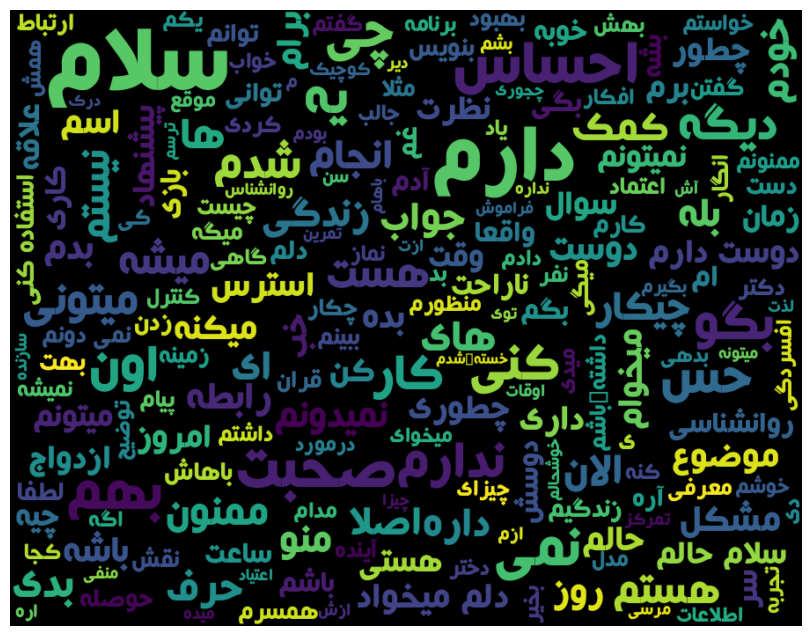

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(
    width=900,
    height=700,
    random_state=42,
    max_font_size=120,
    font_path=font_path
).generate(all_persian_words)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**Bar Plot for Word Frequencies**

In [ ]:
def reshape_reorder_text(text):
    text = re.sub(r'[^\u0600-\u06FF\s]|[؟،]', '', text)
    reshaped_text = arabic_reshaper.reshape(text)
    return get_display(reshaped_text)

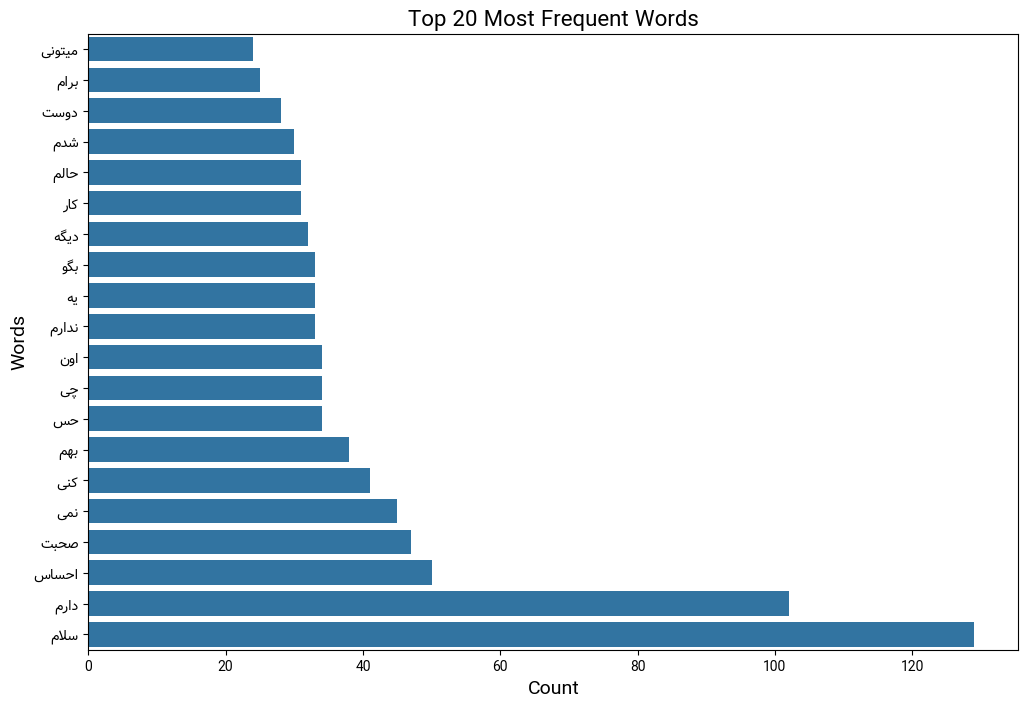

In [ ]:
font_path = '/content/drive/MyDrive/fonts/Vazir.ttf'
fm.fontManager.addfont(font_path)
all_words_list = ' '.join([text for text in temp_data['clean_persian_message']]).split()
word_freq = Counter(all_words_list)
plt.rcParams['font.family'] = 'Vazir'
word_freq_df = pd.DataFrame(word_freq.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)
word_freq_df['word'] = word_freq_df['word'].apply(reshape_reorder_text)
word_freq_df=word_freq_df[word_freq_df['word'].apply(lambda x: x!='')]
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='word', data=word_freq_df.head(20))
plt.title('Top 20 Most Frequent Words', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Words', fontsize=14)
plt.gca().invert_yaxis()
plt.show()

**Word Length Distribution**

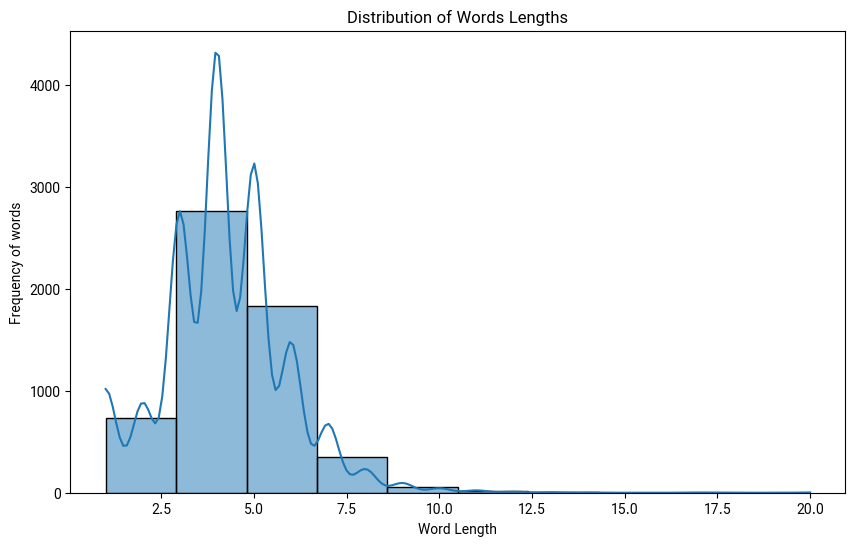

In [ ]:
all_words_list = ' '.join([text for text in temp_data['clean_persian_message']]).split()
word_lengths = [len(word) for word in all_words_list]
plt.figure(figsize=(10, 6))
sns.histplot(word_lengths, bins=10, kde=True)
plt.title('Distribution of Words Lengths')
plt.xlabel('Word Length')
plt.ylabel('Frequency of words')
plt.show()

**Bigram Analysis**

In [ ]:
def clean_text_punctuation(text):
    return re.sub(r'[؟،' + string.punctuation + ']', '', text)

In [ ]:
temp_data['clean_persian_message'] = temp_data['clean_persian_message'].apply(clean_text_punctuation)

<ipython-input-108-e44b15fda9ba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data['clean_persian_message'] = temp_data['clean_persian_message'].apply(clean_text_punctuation)


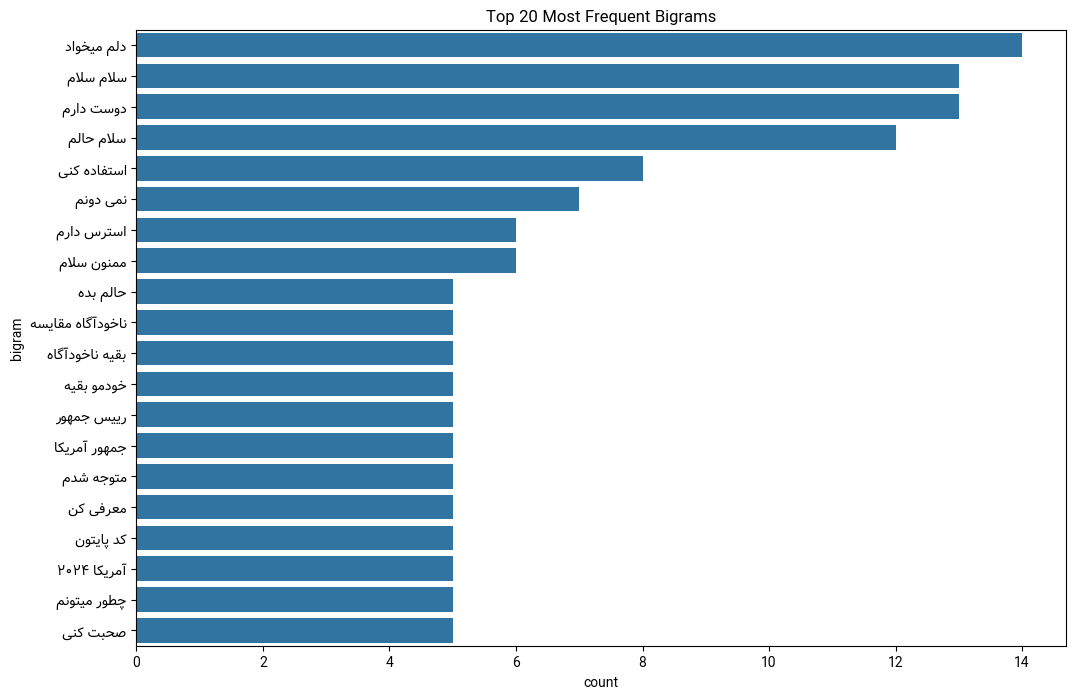

In [ ]:
all_words_list = ' '.join([text for text in temp_data['clean_persian_message']]).split()
bigrams = list(ngrams(all_words_list, 2))
bigram_freq = Counter(bigrams)
bigram_freq_df = pd.DataFrame(bigram_freq.items(), columns=['bigram', 'count'])
bigram_freq_df['bigram'] = bigram_freq_df['bigram'].apply(lambda x: ' '.join(x))
bigram_freq_df['bigram'] = bigram_freq_df['bigram'].apply(reshape_reorder_text)

bigram_freq_df = bigram_freq_df.sort_values(by='count', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='bigram', data=bigram_freq_df.head(20))
plt.title('Top 20 Most Frequent Bigrams')
plt.show()

In [ ]:
# temp_data.to_csv("/content/drive/MyDrive/chatbot dataset/generalized_v4.csv")

#process dataset

show number of token


*   Show Kernel Density Estimate(KDE) toshow the probability of density of data


Mean:39.32


<Figure size 1200x800 with 0 Axes>

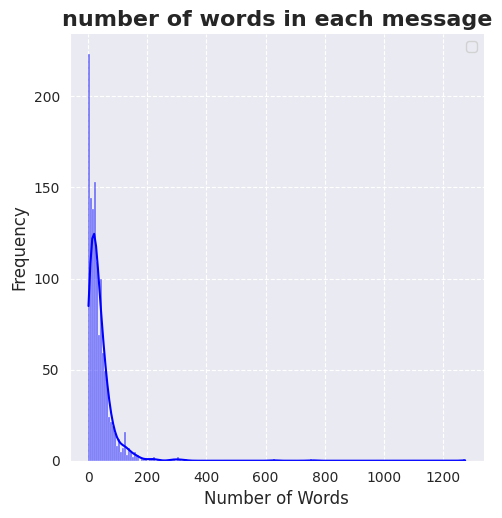

In [ ]:
base_data_fa['num_words']=base_data_fa['clean_message'].str.len()
fig=plt.figure(figsize=(12,8))
sns.set_style('dark')

sns.displot(base_data_fa['num_words'], kde=True,color='Blue')
mean_val = base_data_fa['num_words'].mean()
print(f'\nMean:{mean_val:.2f}')
plt.legend()
plt.title('number of words in each message',fontsize=16,fontweight='bold')
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.grid(True, linestyle='--', alpha=1)
plt.show()

In [ ]:
big_len_data= temp_data[temp_data['clean_message'].apply(lambda x: len(x) >350)]
big_len_data

,level_0,index,message,response,label,related,not-related,clean_message,cleaned_text_len_by_words,clean_message_more,clean_tokenize_message
7,7,7,این متن را ترجمه کن به فارسی \nLaunch of the I...,با تشکر از پیام شما. در مورد درخواست ترجمه‌ی م...,0,0,1,این متن را ترجمه کن به فارسی launch of the ini...,119,این متن را ترجمه کن به فارسی launch of the ini...,"[این, متن, را, ترجمه, کن, به, فارسی, launch, o..."
213,213,214,"Yes, there are mental health conditions where ...",مشکلاتی که درمورد کاهش حافظه و چگونگی تأثیر آن...,0,0,1,"yes, there are mental health conditions where ...",212,"yes, there are mental health conditions where ...","[yes,, there, are, mental, health, conditions,..."
1109,1109,1111,حس میکنم اصلا بهم نمیخوریم. من شاغلم و هر روز ...,مشخص است که در رابطه‌تان با چالش‌های مختلفی مو...,1,1,0,حس می‌کنم اصلا بهم نمی‌خوریم. من شاغلم و هر رو...,140,حس می‌کنم اصلا بهم نمی‌خوریم. من شاغلم و هر رو...,"[حس, می‌کنم, اصلا, بهم, نمی‌خوریم, ., من, شاغل..."


In [ ]:
normalize_size_data=temp_data[temp_data['clean_message'].apply(lambda x: len(x) <=350)]
normalize_size_data.head()

,message,response,label,related,not-related,clean_message,cleaned_text_len_by_words,clean_message_more,clean_tokenize_message
0,سلام,از این که با من در میان گذاشتید خوشحالم. چطور ...,1,1,0,سلام,1,سلام,[سلام]
1,اسم تو چیست,به من می‌توانید با عنوان راهنما یاد کنید. من ا...,1,1,0,اسم تو چیست,3,اسم تو چیست,"[اسم, تو, چیست]"
2,امروز کمی سردرد دارم,متوجه شدم که امروز کمی سردرد دارید. گاهی اوقات...,1,1,0,امروز کمی سردرد دارم,4,امروز کمی سردرد دارم,"[امروز, کمی, سردرد, دارم]"
3,امروز کمی سردرد دارم,احساس ناراحتی که شما تجربه می‌کنید می‌تواند بی...,1,1,0,امروز کمی سردرد دارم,4,امروز کمی سردرد دارم,"[امروز, کمی, سردرد, دارم]"
4,امروز کمی سردرد دارم,طبق اطلاعاتی که در دست دارم، متوجه شده‌ام که م...,1,1,0,امروز کمی سردرد دارم,4,امروز کمی سردرد دارم,"[امروز, کمی, سردرد, دارم]"


<ipython-input-160-78795275a322>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normalize_size_data['num_words']=normalize_size_data['clean_message'].str.len()



Mean:37.30


<Figure size 1200x800 with 0 Axes>

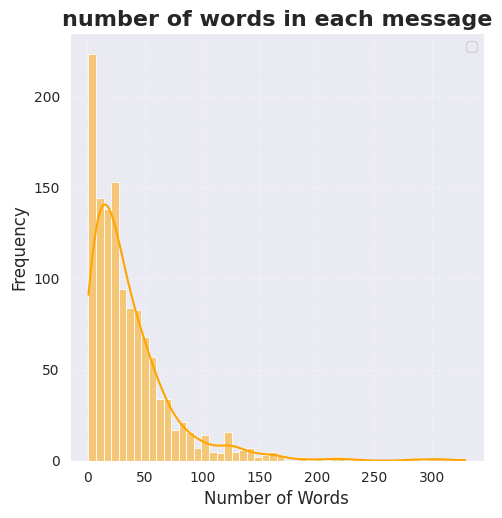

In [ ]:
normalize_size_data['num_words']=normalize_size_data['clean_message'].str.len()
fig=plt.figure(figsize=(12,8))
sns.set_style('dark')

sns.displot(normalize_size_data['num_words'], kde=True,color='orange')
mean_val = normalize_size_data['num_words'].mean()
print(f'\nMean:{mean_val:.2f}')
plt.legend()
plt.title('number of words in each message',fontsize=16,fontweight='bold')
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

#Train Model

In [129]:
base_data_fa=pd.read_csv("/content/drive/MyDrive/chatbot dataset/generalized_v4.csv")
base_data_fa=base_data_fa.drop(columns={'Unnamed: 0','clean_tokenize_message','clean_persian_message','clean_message_more','cleaned_text_len_by_words'})
base_data_fa

,message,response,label,related,not-related,clean_message
0,سلام,از این که با من در میان گذاشتید خوشحالم. چطور ...,1,1,0,سلام
1,اسم تو چیست,به من می‌توانید با عنوان راهنما یاد کنید. من ا...,1,1,0,اسم تو چیست
2,امروز کمی سردرد دارم,متوجه شدم که امروز کمی سردرد دارید. گاهی اوقات...,1,1,0,امروز کمی سردرد دارم
3,امروز کمی سردرد دارم,احساس ناراحتی که شما تجربه می‌کنید می‌تواند بی...,1,1,0,امروز کمی سردرد دارم
4,امروز کمی سردرد دارم,طبق اطلاعاتی که در دست دارم، متوجه شده‌ام که م...,1,1,0,امروز کمی سردرد دارم
...,...,...,...,...,...,...
1255,فکر میکنم کسی به من اهمیتی نمیده,متأسفم که این حس رو داری. می‌دونم که گاهی بیشت...,1,1,0,فکر می‌کنم کسی به من اهمیتی نمیده
1256,فکر میکنم دوستام برای من ارزشی قائل نیستن,می‌فهمم چه احساسی داری. گاهی آدم‌ها مشغله‌های ...,1,1,0,فکر می‌کنم دوستام برای من ارزشی قائل نیستن
1257,چیکار کنم مادرم خوشحال کنم,می‌دونم که خوشحال کردن مادرت برات خیلی مهمه. ش...,1,1,0,چیکار کنم مادرم خوشحال کنم
1258,داشتن مدیریت مالی,به نظر میاد که مدیریت مالی برات داره استرس ایج...,1,1,0,داشتن مدیریت مالی


ignore record with empty or NaN value

In [130]:
base_data_fa = base_data_fa[
    base_data_fa['clean_message'].isnull()==False]
base_data_fa.reset_index()

,index,message,response,label,related,not-related,clean_message
0,0,سلام,از این که با من در میان گذاشتید خوشحالم. چطور ...,1,1,0,سلام
1,1,اسم تو چیست,به من می‌توانید با عنوان راهنما یاد کنید. من ا...,1,1,0,اسم تو چیست
2,2,امروز کمی سردرد دارم,متوجه شدم که امروز کمی سردرد دارید. گاهی اوقات...,1,1,0,امروز کمی سردرد دارم
3,3,امروز کمی سردرد دارم,احساس ناراحتی که شما تجربه می‌کنید می‌تواند بی...,1,1,0,امروز کمی سردرد دارم
4,4,امروز کمی سردرد دارم,طبق اطلاعاتی که در دست دارم، متوجه شده‌ام که م...,1,1,0,امروز کمی سردرد دارم
...,...,...,...,...,...,...,...
1255,1255,فکر میکنم کسی به من اهمیتی نمیده,متأسفم که این حس رو داری. می‌دونم که گاهی بیشت...,1,1,0,فکر می‌کنم کسی به من اهمیتی نمیده
1256,1256,فکر میکنم دوستام برای من ارزشی قائل نیستن,می‌فهمم چه احساسی داری. گاهی آدم‌ها مشغله‌های ...,1,1,0,فکر می‌کنم دوستام برای من ارزشی قائل نیستن
1257,1257,چیکار کنم مادرم خوشحال کنم,می‌دونم که خوشحال کردن مادرت برات خیلی مهمه. ش...,1,1,0,چیکار کنم مادرم خوشحال کنم
1258,1258,داشتن مدیریت مالی,به نظر میاد که مدیریت مالی برات داره استرس ایج...,1,1,0,داشتن مدیریت مالی


In [131]:
#update label column name
label_columns = ['related', 'not-related']

y = base_data_fa[label_columns].values

mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=1)
train_indices, valid_indices = next(mskf.split(base_data_fa, y))

train = base_data_fa.iloc[train_indices].reset_index(drop=True)
valid = base_data_fa.iloc[valid_indices].reset_index(drop=True)

x_train, y_train = train['clean_message'].values.tolist(), train[label_columns].values.tolist()
x_valid, y_valid = valid['clean_message'].values.tolist(), valid[label_columns].values.tolist()

y_train_df = pd.DataFrame(y_train, columns=label_columns)

label_distribution = y_train_df.apply(pd.Series.value_counts).T.fillna(0).astype(int)
label_distribution.columns = ['count_0', 'count_1']
print(label_distribution)

             count_0  count_1
related          418      590
not-related      590      418


In [132]:
y_valid_df = pd.DataFrame(y_valid, columns=label_columns)
label_distribution_valid = y_valid_df.apply(pd.Series.value_counts).T.fillna(0).astype(int)
label_distribution_valid.columns = ['count_0', 'count_1']

print(label_distribution_valid)

             count_0  count_1
related          104      148
not-related      148      104


In [133]:
len(x_train)

1008

In [134]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

In [135]:
def build_dataset(x_train,y_train,x_valid,y_valid,MAX_LENGTH):
  train_encodings = tokenizer(x_train, truncation=True, padding="max_length", max_length=MAX_LENGTH)
  valid_encodings = tokenizer(x_valid, truncation=True, padding="max_length", max_length=MAX_LENGTH)
  train_dataset = Dataset(train_encodings, y_train)
  valid_dataset = Dataset(valid_encodings, y_valid)
  return train_dataset,valid_dataset

def train_arg():
    training_args = TrainingArguments(
    output_dir="./output/best-model-v1",
    report_to=None,
    num_train_epochs=10,
    gradient_accumulation_steps=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy=IntervalStrategy.STEPS,
    save_total_limit=1,
    logging_dir="./logs",
    logging_strategy=IntervalStrategy.STEPS,
    logging_steps=250,
    eval_steps=250,
    load_best_model_at_end=True,
  )
    return training_args

In [136]:
def evaluate_func(trainer):
  trainer.evaluate()
  predictions = trainer.predict(valid_dataset)
  predicted_logits = predictions.predictions
  print(f"Type of predicted_logits: {type(predicted_logits)}")
  if isinstance(predicted_logits, tuple):
        predicted_logits = predicted_logits[0]
  if not isinstance(predicted_logits, np.ndarray):
        predicted_logits = np.array(predicted_logits)
  if len(predicted_logits.shape) == 3:
        predicted_logits = predicted_logits[:, 0, :]
  predicted_probabilities = expit(predicted_logits)
  threshold = 0.5
  predicted_classes = (predicted_probabilities >= threshold).astype(int)
  precision, recall, f1, _ = precision_recall_fscore_support(y_valid, predicted_classes, average=None)
  accuracy = accuracy_score(y_valid, predicted_classes)
  return precision, recall, f1,accuracy

In [137]:
MAX_LENGTH = 256
metrics_df = pd.DataFrame(columns=["Models_name", "Precision", "Recall", "F1_score", "Accuracy"])
confusion_matrices = []

In [138]:
models_list=models_list_1
# model_list=models_list_2
models_name=models_name_1
# models_name=models_name_2
print(model_list)
for x in range(len(models_list)):
  torch.cuda.empty_cache()

  i=models_list[x]
  print(i)
  tokenizer = AutoTokenizer.from_pretrained(i)
  model = AutoModelForSequenceClassification.from_pretrained(i, num_labels=2, ignore_mismatched_sizes=True)
  model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
  for param in model.parameters():
      param.data = param.data.contiguous()

  training_args = train_arg()
  train_dataset,valid_dataset=build_dataset(x_train,y_train,x_valid,y_valid,MAX_LENGTH)
  trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=train_dataset,
      eval_dataset=valid_dataset,
  )
  trainer.train()
  precision, recall, f1,accuracy=evaluate_func(trainer)
  new_data = pd.DataFrame({
    "Models_name": [models_name[x]],
    "Precision": [precision],
    "Recall": [recall],
    "F1_score": [f1],
    "Accuracy": [accuracy]
  })

  metrics_df = pd.concat([metrics_df, new_data], ignore_index=True)

  model_confusion_matrices = []
  predicted_classes = trainer.predict(valid_dataset).predictions



  if isinstance(predicted_classes, tuple) :
    predicted_classes = predicted_classes[0]
  predicted_classes = np.array(predicted_classes)
  # print(f"Type after conversion: {type(predicted_classes)}")

  if len(predicted_classes.shape) > 2:
    predicted_classes = predicted_classes.reshape(predicted_classes.shape[0], -1)
    # print(f"Shape after reshaping: {predicted_classes.shape}")

  y_valid_np = np.array(y_valid)



  predicted_classes = (expit(predicted_classes) >= 0.5).astype(int)


  for j in range(len(label_columns)):
      print(f"Computing confusion matrix for label: {label_columns[j]}")
      cm = confusion_matrix(y_valid_np[:, j], predicted_classes[:, j])

      # cm = confusion_matrix(y_valid[:, j], predicted_classes[:, j])
      model_confusion_matrices.append(cm)
  confusion_matrices.append(model_confusion_matrices)


  print(f"{models_name[x]} evaluates:")
  for k, label in enumerate(label_columns):
    print(f"Class '{label}': Precision: {precision[k]:.4f}, Recall: {recall[k]:.4f}, F1: {f1[k]:.4f}")
  print(f"Overall accuracy: {accuracy:.4f}")
  print("-------------------------------------------------------------------------\n")

['funnel-transformer/medium', 'google/electra-base-discriminator', 'facebook/bart-base', 'facebook/bart-large', 'HooshvareLab/bert-fa-base-uncased', 'FacebookAI/xlm-roberta-base']
funnel-transformer/medium


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of FunnelForSequenceClassification were not initialized from the model checkpoint at funnel-transformer/medium and are newly initialized: ['classifier.linear_hidden.bias', 'classifier.linear_hidden.weight', 'classifier.linear_out.bias', 'classifier.linear_out.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = tor

Step,Training Loss,Validation Loss
250,0.686300,0.664997
500,0.668900,0.623470
750,0.627400,0.554989
1000,0.604700,0.541603
1250,0.583500,0.538509


Type of predicted_logits: <class 'numpy.ndarray'>


<ipython-input-138-0343c48e8f56>:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, new_data], ignore_index=True)


Computing confusion matrix for label: related
Computing confusion matrix for label: not-related
funnel-transformer-medium evaluates:
Class 'related': Precision: 0.6916, Recall: 1.0000, F1: 0.8177
Class 'not-related': Precision: 1.0000, Recall: 0.3654, F1: 0.5352
Overall accuracy: 0.7381
-------------------------------------------------------------------------

google/electra-base-discriminator


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp

Step,Training Loss,Validation Loss
250,0.608400,0.581085
500,0.581100,0.472603
750,0.543300,0.452975
1000,0.502900,0.439857
1250,0.473200,0.446969


Type of predicted_logits: <class 'numpy.ndarray'>


Computing confusion matrix for label: related
Computing confusion matrix for label: not-related
electra-base evaluates:
Class 'related': Precision: 0.7711, Recall: 0.8649, F1: 0.8153
Class 'not-related': Precision: 0.7765, Recall: 0.6346, F1: 0.6984
Overall accuracy: 0.7698
-------------------------------------------------------------------------

facebook/bart-base


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scale

Step,Training Loss,Validation Loss
250,0.544400,0.445276
500,0.462800,0.500028
750,0.388200,0.578470
1000,0.322900,0.620106
1250,0.281100,0.699400


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

Type of predicted_logits: <class 'tuple'>


Computing confusion matrix for label: related
Computing confusion matrix for label: not-related
bart-base evaluates:
Class 'related': Precision: 0.8138, Recall: 0.7973, F1: 0.8055
Class 'not-related': Precision: 0.7264, Recall: 0.7404, F1: 0.7333
Overall accuracy: 0.7738
-------------------------------------------------------------------------

facebook/bart-large


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-large and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scal

Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss
250,0.551400,0.474969
500,0.476700,0.481107
750,0.447600,0.477317
1000,0.397000,0.490086
1250,0.366800,0.550593


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

Type of predicted_logits: <class 'tuple'>


Computing confusion matrix for label: related
Computing confusion matrix for label: not-related
bart-large evaluates:
Class 'related': Precision: 0.8101, Recall: 0.8649, F1: 0.8366
Class 'not-related': Precision: 0.7872, Recall: 0.7115, F1: 0.7475
Overall accuracy: 0.8016
-------------------------------------------------------------------------

HooshvareLab/bert-fa-base-uncased


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss
250,0.364100,0.476552
500,0.134600,0.708711
750,0.053700,0.774959
1000,0.023800,0.910934
1250,0.012600,0.962155


Type of predicted_logits: <class 'numpy.ndarray'>


Computing confusion matrix for label: related
Computing confusion matrix for label: not-related
ParsBERT evaluates:
Class 'related': Precision: 0.8836, Recall: 0.8716, F1: 0.8776
Class 'not-related': Precision: 0.8208, Recall: 0.8365, F1: 0.8286
Overall accuracy: 0.8571
-------------------------------------------------------------------------

FacebookAI/xlm-roberta-base


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.Gr

Step,Training Loss,Validation Loss
250,0.573800,0.514278
500,0.389200,0.565510
750,0.292900,0.680170
1000,0.211400,0.899359
1250,0.154600,0.987133


Type of predicted_logits: <class 'numpy.ndarray'>


Computing confusion matrix for label: related
Computing confusion matrix for label: not-related
XLM-Roberta-base evaluates:
Class 'related': Precision: 0.7988, Recall: 0.9122, F1: 0.8517
Class 'not-related': Precision: 0.8415, Recall: 0.6635, F1: 0.7419
Overall accuracy: 0.8095
-------------------------------------------------------------------------



In [141]:
metrics_df

,Models_name,Precision,Recall,F1_score,Accuracy
0,funnel-transformer-medium,"[0.6915887850467289, 1.0]","[1.0, 0.36538461538461536]","[0.8176795580110497, 0.5352112676056338]",0.738095
1,electra-base,"[0.7710843373493976, 0.7764705882352941]","[0.8648648648648649, 0.6346153846153846]","[0.8152866242038217, 0.6984126984126985]",0.769841
2,bart-base,"[0.8137931034482758, 0.7264150943396226]","[0.7972972972972973, 0.7403846153846154]","[0.8054607508532423, 0.7333333333333334]",0.773810
3,bart-large,"[0.810126582278481, 0.7872340425531915]","[0.8648648648648649, 0.7115384615384616]","[0.8366013071895425, 0.7474747474747475]",0.801587
4,ParsBERT,"[0.8835616438356164, 0.8207547169811321]","[0.8716216216216216, 0.8365384615384616]","[0.8775510204081631, 0.8285714285714286]",0.857143
5,XLM-Roberta-base,"[0.7988165680473372, 0.8414634146341463]","[0.9121621621621622, 0.6634615384615384]","[0.8517350157728706, 0.7419354838709676]",0.809524


In [142]:
# metrics_df.to_csv("/content/drive/MyDrive/chatbot dataset/metric_m1_e10.csv")

#Show confusion matrix

In [ ]:
for model_idx, model_cms in enumerate(confusion_matrices):
    for label_idx, cm in enumerate(model_cms):
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
        plt.title(f'Confusion Matrix for Model {models_name[model_idx]} - Class {label_columns[label_idx]}')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()